<a href="https://colab.research.google.com/github/pbuslaev/cphmd_ligand_param/blob/main/prep_ligand_for_gmx_cphmd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook has to be run on Google colab

<a target="_blank" href="https://colab.research.google.com/github/pbuslaev/test_ipynb/blob/main/test_user_input.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title Conda installation
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()

In [1]:
#@title Intall packages
%%capture
!pip install dimorphite_dl --upgrade
!mamba install -c conda-forge rdkit sympy openff-toolkit

In [2]:
#@title Import packages
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
from IPython.display import SVG
from dimorphite_dl import DimorphiteDL

from openff.toolkit import Molecule, Topology, ForceField

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
  get_ipython().events.register('pre_run_cell', set_css)

This is Molecule 0


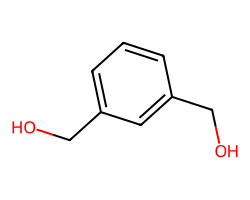

This is Molecule 1


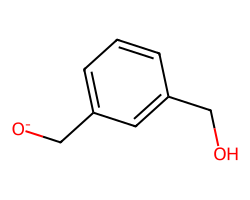

This is Molecule 2


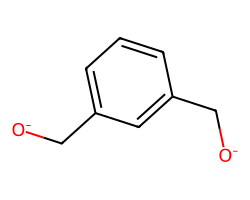

In [53]:
#@title Input molecule
#@markdown Please provide molecule SMILES. We will generate its protonation
#@markdown states. Also, specify pH range for which to create states.
# As a two state example we will use SM-26 from SAMP7 challenge
# (https://github.com/samplchallenges/SAMPL7/tree/master/physical_property)
# SMILES: O=S(CCC1=CC=CC=C1)(NC(C)=O)=O
# test 1: c1cc(N)c(N)cc1
# test 2: c1cc(CO)cc(CO)c1
# pKa = 4.91
# (https://github.com/samplchallenges/SAMPL7/blob/master/physical_property/experimental_data/Experimental_Properties_of_SAMPL7_Compounds.pdf)
smiles = "c1cc(CO)cc(CO)c1" #@param {type: "string"}
min_ph = -10 #@param {type: "number"}
max_ph = 24 #@param {type: "number"}
dimorphite_dl = DimorphiteDL(
    min_ph=min_ph,
    max_ph=max_ph,
    max_variants=256,
    label_states=False,
    pka_precision=0.1
)
mols = [Chem.MolFromSmiles(mol) for mol in dimorphite_dl.protonate(smiles)]
mols = sorted(mols, key = lambda x: Chem.GetFormalCharge(x), reverse=True)
# Now mols[0] is the highest protonation state
for i, m in enumerate(mols):
    print(f"This is Molecule {i}")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

In [54]:
#@title Select molecules
#@markdown Which molecule states do you want to use?
#@markdown The molecule ids are shown in the previous cell.
mol1 = True #@param {type:"boolean"}
mol2 = True #@param {type:"boolean"}
mol3 = True #@param {type:"boolean"}
mol4 = True #@param {type:"boolean"}
mol5 = True #@param {type:"boolean"}
mol6 = False #@param {type:"boolean"}
mol7 = False #@param {type:"boolean"}
mol8 = False #@param {type:"boolean"}
mol9 = False #@param {type:"boolean"}
mol10 = False #@param {type:"boolean"}

mols_to_use = [
    mol1, mol2, mol3, mol4, mol5, mol6, mol7, mol8, mol9, mol10,
][:len(mols)]

mols = [mols[i] for i in range(len(mols)) if mols_to_use[i]]

This is Molecule 0


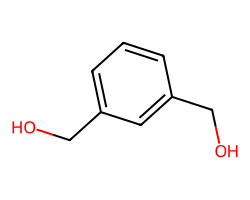

This is Molecule 1


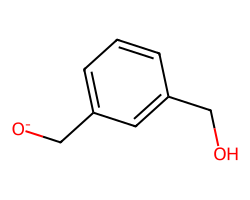

This is Molecule 2


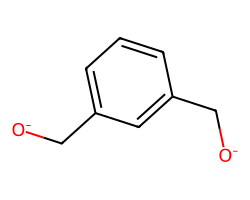

In [55]:
#@title Selected molecules
#@markdown The foloweing molecules will be used in the furhter analysis.
for i, m in enumerate(mols):
    print(f"This is Molecule {i}")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

In [56]:
#@title Get titratable site
# Highest protonation state is always in state[0]
titratable_sites = []
# pmol is a protonated molecule - always in the highest available protonation
# state
pmol = mols[0]
from rdkit.Chem import rdFMCS
res = rdFMCS.FindMCS([pmol, pmol])
similar_patt = Chem.MolFromSmarts(res.smartsString)
# This is a constant mol[0] substructure match
subst_matches_pmol = pmol.GetSubstructMatches(similar_patt)[0]
for m in mols[1:]:
    subst_matches = m.GetSubstructMatches(similar_patt)[0]
    for a0, a in zip(subst_matches_pmol, subst_matches):
        if (pmol.GetAtomWithIdx(a0).GetFormalCharge() !=
            m.GetAtomWithIdx(a).GetFormalCharge()
        ):
            titratable_sites.append(a0)
titratable_sites = list(set(titratable_sites))

In [57]:
titratable_sites

[0, 8]

In [84]:
#@title Get list of symmetrical titratable sites
from rdkit.Chem import rdFMCS
# We search for symmetrical sites based on the highest protonation states
# NOTE: If the user selects not to include the highest protonation state
# this behaviour can cause problems.
res = rdFMCS.FindMCS([pmol, pmol])
similar_patt = Chem.MolFromSmarts(res.smartsString)
sym_subst_matches = pmol.GetSubstructMatches(similar_patt, uniquify=False)
subst_matches = sym_subst_matches
print(subst_matches)
symmetrical_sites = {x.GetIdx():[x.GetIdx()] for x in pmol.GetAtoms()}
if len(subst_matches) > 1:
    for sm in subst_matches[1:]:
        for ts in titratable_sites:
            if sm[subst_matches_pmol.index(ts)] not in symmetrical_sites[ts]:
                symmetrical_sites[ts].append(sm[subst_matches_pmol.index(ts)])
                symmetrical_sites[sm[subst_matches_pmol.index(ts)]].append(ts)
symmetrical_sites

((0, 1, 2, 3, 4, 5, 6, 9, 7, 8), (8, 7, 6, 5, 4, 3, 2, 9, 1, 0))


{0: [0, 8],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8, 0],
 9: [9]}

In [85]:
symmetrical_sites

{0: [0, 8],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8, 0],
 9: [9]}

In [86]:
#@title Get list of sites with multiple hydrogens
sites_with_multiple_hs = []
for ts in titratable_sites:
    if (
        pmol.GetAtomWithIdx(ts).GetNumExplicitHs()
        + pmol.GetAtomWithIdx(ts).GetNumImplicitHs()
        > 1
    ):
        sites_with_multiple_hs.append(ts)
sites_with_multiple_hs

[]

In [87]:
#@title Highlight sites with multiple hydrogens
import textwrap
if sites_with_multiple_hs:
    print(
        textwrap.fill(
            (
                f"We detected {len(sites_with_multiple_hs)} sites to which "
                + "multiple hydrogens are attached. Please, take a careful "
                + "look and let us know whether we should consider those sites "
                + "as multisite with each hydrogen titrating separately, or as "
                + "single site, where only one hydrogen is titrated. Note, "
                + "that we highlight the titratable sites for the molecule in "
                + "the highest protonation state."
            ),
            120
        )
    )
    colors = [(1.0, 0.0, 0.0, 0.2)]
    for i, a in enumerate(sites_with_multiple_hs):
        (pmol.GetAtomWithIdx(a)).SetProp('atomNote', str(i+1))
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    at_highlights = {x: [colors[0]] for x in sites_with_multiple_hs}
    at_rads = {x: 0.5 for x in sites_with_multiple_hs}
    d2d.DrawMoleculeWithHighlights(pmol,"", at_highlights,{}, at_rads, {})
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    for a in sites_with_multiple_hs:
        (pmol.GetAtomWithIdx(a)).SetProp('atomNote', '')
else:
    mHs = None
    print(
        "No sites to which multiple hydrogens are attached were detected. "
        + " You can skip the next step."
    )

No sites to which multiple hydrogens are attached were detected.  You can skip the next step.


In [62]:
#@title Select treatment of multi-hydrogen sites
#@markdown Do you want to treat titratable sites with multiple hydrogens
#@markdown attached as single multisite or no? Default is no. If you want
#@markdown to treat those with multisite representation tick the corresponding
#@markdown variable. The id of titratable sites are shown in the previous cell.
multiHs_titratable_site_1 = True #@param {type:"boolean"}
multiHs_titratable_site_2 = True #@param {type:"boolean"}
multiHs_titratable_site_3 = False #@param {type:"boolean"}
multiHs_titratable_site_4 = False #@param {type:"boolean"}
multiHs_titratable_site_5 = False #@param {type:"boolean"}

mHs = [
    multiHs_titratable_site_1,
    multiHs_titratable_site_2,
    multiHs_titratable_site_3,
    multiHs_titratable_site_4,
    multiHs_titratable_site_5,
][:len(sites_with_multiple_hs)]

In [15]:
mHs

[True, True]

For molecule 1 symmetrical states were detected:


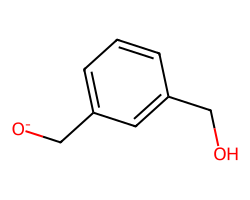

These are found symmetrical states:


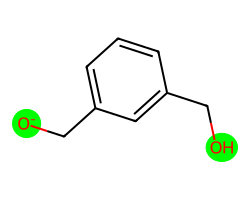

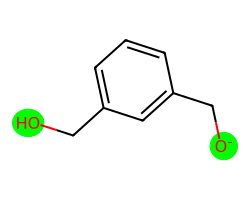

In [88]:
#@title Symmetrical states treatment
states = {}  # Dictionary of states and state treatment. Each state has a
# molecule, number of states and number of states for consideration, atoms with
# different charges of the symmetrical states, and atoms with multiple hydrogens
# NOTE: numbering is given in the pmol indices
# NOTE: state treatment should be fixed/changed after user input is provided
for i, m in enumerate(mols):
    from rdkit.Chem import rdFMCS
    res = rdFMCS.FindMCS([pmol, pmol])
    similar_patt = Chem.MolFromSmarts(res.smartsString)
    subst_matches = m.GetSubstructMatches(similar_patt)[0]
    charges = {}
    for a in symmetrical_sites:
        # We collect formal charges for each symmetrical state.
        charges[a] = [
            m.GetAtomWithIdx(
                subst_matches[subst_matches_pmol.index(a)]
            ).GetFormalCharge()
        ]
        # If there is only one symmetrical site for an atom, nothing to do.
        if len(symmetrical_sites[a]) == 1:
            continue
        # Add symmetrical charges to the atom charge list
        for idx in symmetrical_sites[a][1:]:
            charges[a].append(
                m.GetAtomWithIdx(
                    subst_matches[subst_matches_pmol.index(idx)]
                ).GetFormalCharge()
            )

    # If for all atoms in this states there is only on charge, nothing to do.
    if all([len(list(set(x))) == 1 for x in charges.values()]):
        states[i] = (m, 1, 1, None, None)
        continue
    print(f"For molecule {i} symmetrical states were detected:")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    print("These are found symmetrical states:")
    # Symmetrical atoms with different charges
    atoms_to_change = [x for x in charges if len(charges[x]) > 1]
    # Atoms for which there is no difference between states, but their charge is
    # different from the highest protonation state
    atoms_with_dif_charges = [
        x for x in charges if len(charges[x]) == 1 and
        charges[x][0] != pmol.GetAtomWithIdx(x).GetFormalCharge()
    ]
    charge_combinations = list(zip(*[charges[x] for x in atoms_to_change]))
    # We collect already seen sets of charges in state_charges
    state_charges = []
    from copy import deepcopy
    for c in charge_combinations:
        m_new = deepcopy(pmol)
        # We set up state specific symmetrical charges
        for a in atoms_with_dif_charges:
            m_new.GetAtomWithIdx(a).SetFormalCharge(
                pmol.GetAtomWithIdx(a).GetFormalCharge() - 1
            )
            m_new.GetAtomWithIdx(a).SetNumExplicitHs(
                pmol.GetAtomWithIdx(a).GetNumImplicitHs() +
                pmol.GetAtomWithIdx(a).GetNumExplicitHs() - 1
            )
        # We set up other state charges
        for a_charge, a in zip(c, atoms_to_change):
            if a_charge != pmol.GetAtomWithIdx(a).GetFormalCharge():
                m_new.GetAtomWithIdx(a).SetFormalCharge(a_charge)
                m_new.GetAtomWithIdx(a).SetNumExplicitHs(
                    pmol.GetAtomWithIdx(a).GetNumImplicitHs() +
                    pmol.GetAtomWithIdx(a).GetNumExplicitHs() - 1
                )
        # We do nothing if there are
        if [x.GetFormalCharge() for x in m_new.GetAtoms()] in state_charges:
            continue
        state_charges.append([x.GetFormalCharge() for x in m_new.GetAtoms()])
        d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
        colors = [(0.0, 1.0, 0.0, 0.2)]
        at_highlights = {x: [colors[0]] for x in atoms_to_change}
        at_rads = {x: 0.5 for x in atoms_to_change}
        d2d.DrawMoleculeWithHighlights(m_new,"", at_highlights,{}, at_rads, {})
        d2d.FinishDrawing()
        display(SVG(d2d.GetDrawingText()))
    states[i] = (
        m, len(state_charges), 1, (atoms_to_change, state_charges), None
    )
if all([x[1] == 1 for x in states.values()]):
    ss = None
    print(
        "No symmetrical states were found "
        + " You can skip the next step."
    )

In [89]:
#@title Select treatment of symmetrical states
#@markdown Please, select whether to inclue symmetrical states for a molecule
#@markdown or not. If for a particular molecule there are no symmetrical
#@markdown states available, selecting True won't influence the behaviour
use_symmetrical_states_molecule_0 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_1 = True #@param {type:"boolean"}
use_symmetrical_states_molecule_2 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_3 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_4 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_5 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_6 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_7 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_8 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_9 = False #@param {type:"boolean"}

ss = [
    use_symmetrical_states_molecule_0,
    use_symmetrical_states_molecule_1,
    use_symmetrical_states_molecule_2,
    use_symmetrical_states_molecule_3,
    use_symmetrical_states_molecule_4,
    use_symmetrical_states_molecule_5,
    use_symmetrical_states_molecule_6,
    use_symmetrical_states_molecule_7,
    use_symmetrical_states_molecule_8,
    use_symmetrical_states_molecule_9,
][:len(states)]

In [90]:
#@title Update states information
for i, s in zip(states.keys(), states.values()):
    if ss:
        t = ss[i]
    else:
        t = False
    if t:
        states[i] = (s[0], s[1], s[1], s[3], s[4])
    if mHs:
        from rdkit.Chem import rdFMCS
        res = rdFMCS.FindMCS([pmol, pmol])
        similar_patt = Chem.MolFromSmarts(res.smartsString)
        subst_matches = s[0].GetSubstructMatches(similar_patt)[0]
        factor = 1
        atoms_with_mhs = []
        for idx in sites_with_multiple_hs:
            if not mHs[sites_with_multiple_hs.index(idx)]:
                continue
            a = s[0].GetAtomWithIdx(
                subst_matches[subst_matches_pmol.index(idx)]
            )
            a_p = pmol.GetAtomWithIdx(idx)
            if (
                (a.GetNumExplicitHs() + a.GetNumImplicitHs()) !=
                (a_p.GetNumExplicitHs() + a_p.GetNumImplicitHs())
            ):
                # TODO: we also need to add symmetrical atoms
                atoms_with_mhs.append(idx)
                factor *= (a_p.GetNumExplicitHs() + a_p.GetNumImplicitHs())
        states[i] = (s[0], s[1], states[i][1] * factor, s[3], atoms_with_mhs)
states

{0: (<rdkit.Chem.rdchem.Mol at 0x7e4413509850>, 1, 1, None, None),
 1: (<rdkit.Chem.rdchem.Mol at 0x7e441350aea0>,
  2,
  2,
  ([0, 8], [[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, -1, 0]]),
  None),
 2: (<rdkit.Chem.rdchem.Mol at 0x7e441350b1b0>, 1, 1, None, None)}

We found the following transitions between protonation states:
Transition 0


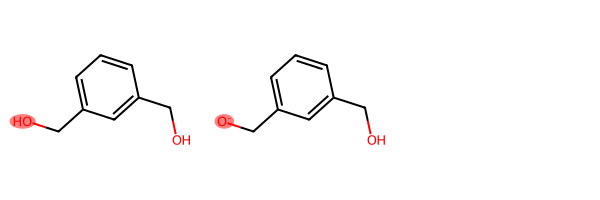

Transition 1


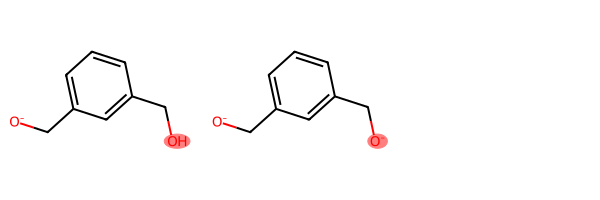

In [91]:
#@title Show state transitions
state_transitions = []
for i, m1 in enumerate(mols):
    for j, m2 in enumerate(mols[i+1:]):
        from rdkit.Chem import rdFMCS
        res = rdFMCS.FindMCS([pmol, pmol])
        similar_patt = Chem.MolFromSmarts(res.smartsString)
        subst_matches1 = m1.GetSubstructMatches(similar_patt)[0]
        subst_matches2 = m2.GetSubstructMatches(similar_patt)[0]
        n_diffs = 0
        for idx in titratable_sites:
            if (
                m1.GetAtomWithIdx(
                    subst_matches1[subst_matches_pmol.index(idx)]
                ).GetFormalCharge() !=
                m2.GetAtomWithIdx(
                    subst_matches2[subst_matches_pmol.index(idx)]
                ).GetFormalCharge()
            ):
                n_diffs += 1
        if n_diffs != 1:
            continue
        state_transitions.append((i, i + 1+j, m1, m2))

def view_difference(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    target_atm2 = []
    for a1, a2 in zip(match1, match2):
        if (
            mol1.GetAtomWithIdx(a1).GetFormalCharge() !=
            mol2.GetAtomWithIdx(a2).GetFormalCharge()
        ):
            target_atm1.append(a1)
            target_atm2.append(a2)
    d2d = Draw.MolsToGridImage(
        [mol1, mol2],
        highlightAtomLists=[target_atm1, target_atm2],
        useSVG = True,
    )
    display(d2d)

print("We found the following transitions between protonation states:")
for i, st_t in enumerate(state_transitions):
    print(f"Transition {i}")
    view_difference(st_t[2], st_t[3])

In [92]:
state_transitions

[(0,
  1,
  <rdkit.Chem.rdchem.Mol at 0x7e441350aea0>),
 (1,
  2,
  <rdkit.Chem.rdchem.Mol at 0x7e441350b1b0>)]

In [93]:
#@title Provide pKa values for transitions between protonated states
#@markdown Please, provide pKa values for protonated states.
pka_0 = 2 #@param {type:"number"}
pka_1 = 3 #@param {type:"number"}
pka_2 = 4 #@param {type:"number"}
pka_3 = 5 #@param {type:"number"}
pka_4 = 0.0 #@param {type:"number"}
pka_5 = 0.0 #@param {type:"number"}
pka_6 = 0.0 #@param {type:"number"}
pka_7 = 0.0 #@param {type:"number"}
pka_8 = 0.0 #@param {type:"number"}
pka_9 = 0.0 #@param {type:"number"}

pkas = [
    pka_0, pka_1, pka_2, pka_3, pka_4,
    pka_5, pka_6, pka_7, pka_8, pka_9,
][:len(state_transitions)]

In [94]:
states

{0: (<rdkit.Chem.rdchem.Mol at 0x7e4413509850>, 1, 1, None, None),
 1: (<rdkit.Chem.rdchem.Mol at 0x7e441350aea0>,
  2,
  2,
  ([0, 8], [[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, -1, 0]]),
  None),
 2: (<rdkit.Chem.rdchem.Mol at 0x7e441350b1b0>, 1, 1, None, None)}

In [96]:
#@title Generate pKa matrix equation
import numpy as np
from sympy import Matrix, MatrixSymbol, symbols
if len(mols) == 2 and all(states[x][2] == 1 for x in states):
    print(f"Single state should be used. pKa = {pkas[0]}")
else:
    ph = symbols("pH")
    A = np.zeros((len(state_transitions) + 1, len(mols)), dtype = 'int')
    b = MatrixSymbol('b', len(state_transitions) + 1, 1).as_explicit()
    bsubs = {b[0,0]: ph}
    for i, (tr, pka) in enumerate(zip(state_transitions, pkas)):
        state1 = tr[0]
        state2 = tr[1]
        n = states[state1][2]
        m = states[state2][2]
        if Chem.GetFormalCharge(tr[2]) > Chem.GetFormalCharge(tr[3]):
            A[i+1, state1] =-1
            A[i+1, state2] = 1
            bsubs[b[i + 1, 0]] = pka - np.log10(n/m) - ph
        else:
            A[i+1, state1] = 1
            A[i+1, state2] = -1
            bsubs[b[i + 1, 0]] = pka - np.log10(m/n) - ph
    A[0, 0] = 1
    m = Matrix(A)
    _, inds = m.T.rref()
    removed_inds = [x for x in range(len(state_transitions) + 1) if x not in inds]
    Ar = A[list(inds)]
    Ad = A[list(removed_inds)]
    mr = Matrix(Ar)
    md = Matrix(Ad)
    p = MatrixSymbol('p', len(mols), 1).as_explicit()
    b = b.subs(bsubs)
    br = MatrixSymbol('br', len(inds), 1).as_explicit()
    brsubs = {}
    for i, idx in enumerate(inds):
        brsubs[br[i, 0]] = b[idx, 0]

    br = br.subs(brsubs)
    br

    sol = mr.solve(br)
    print(
        "Recommended pKa values for protonations states, considering all previous "
        + "input are:"
    )
    for i in range(len(mols)):
        print(f"State {i}: pKa = {sol[i,0]}")

Recommended pKa values for protonations states, considering all previous input are:
State 0: pKa = pH
State 1: pKa = 2.30102999566398
State 2: pKa = 5.0 - pH


In [100]:
#@title Topology and structure general behavior
#@markdown Do you want us to generate topology and molecule structure with
#@markdown Open Force Field? If no, you would need to provide topologies in
#@markdown **.itp** format in the following steps.
is_generation_needed = True #@param {type:"boolean"}
ff_to_use = "openff-2.1.0.offxml" #@param {type:"string"}
molecule_name = "MOL" #@param {type:"string"}
_mols = []
charges = []
if is_generation_needed:
    ff = ForceField(ff_to_use)
    for _i, m in enumerate(mols):
        _m = Molecule.from_rdkit(m)
        _m.generate_conformers()
        interchange = ff.create_interchange(_m.to_topology())
        charges.append(
            [a.partial_charge.magnitude for a in interchange.topology.atoms]
        )
        _mols.append(_m.to_rdkit())
        if _i == 0:
            interchange.to_gromacs(f"molecule_{_i}")
        else:
            interchange.to_top(f"molecule_{_i}.top")

_base_mol = _mols[0]
charge_table =[charges[0]]

def _basic_treatment(
        idx: int,
        match1_list: list[int],
        match2_list: list[int],
        charge_list: list[float],
    ) -> dict:
    """
    """
    _tmp = {}
    _tmp[0] = []
    for i in range(len(charge_table[0])):
        if i in match1_list:
            _ch_idx = match2_list[match1_list.index(i)]
            _tmp[0].append(charge_list[_ch_idx])
        else:
            _tmp[0].append(0)
    return _tmp

def _only_mhs_treatment(
        idx: int,
        match1_list: list[int],
        match2_list: list[int],
        charge_list: list[float],
    ) -> dict:
    """
    """
    _tmp = {_s: [] for _s in range(states[idx+1][2])}

    mhs = states[idx+1][4]
    # we search for hydrogens attached to any of mh sites
    hs = {}
    for i in mhs:
        hs[i] = []
        _a = _base_mol.GetAtomWithIdx(i)
        for _b in _a.GetBonds():
            _oi = _b.GetBeginAtomIdx() if _b.GetBeginAtomIdx() != i else _b.GetEndAtomIdx()
            if _base_mol.GetAtomWithIdx(_oi).GetSymbol() == "H":
                hs[i].append(_oi)

    # Generate combinations for states
    import itertools
    mh_nstates = [len(hs[i]) for i in hs]
    mh_h_states = list(itertools.product(*[range(x) for x in mh_nstates]))
    assert len(mh_h_states) == states[idx+1][2], "Incorrect number of states"
    def _is_mhh(idx: int) -> int:
        """
        Check if atom is a hydrogen connected to mh atom.
        """
        for _idx in mhs:
            if idx in hs[_idx]:
                return _idx
            else:
                continue
        return -1

    for i in range(len(charge_table[0])):
        _mh_idx = _is_mhh(i)
        if _mh_idx >= 0:
            # We are treating mh hydrogen
            # Get hydrogen charges in deprotonated molecule
            _ch = []
            for _j in hs[_mh_idx]:
                if _j in match1_list:
                    _ch_idx = match2_list[match1_list.index(_j)]
                    _ch.append(charge_list[_ch_idx])
            # Check that all charges are identical
            for _ch1 in _ch[1:]:
                assert np.abs(_ch[0] - _ch1) < 1e-5, "Multiple hydrogens at the same site are expexted to have similar charges"
            for _idx, _s in enumerate(mh_h_states):
                _ha_idx = mhs.index(_mh_idx)
                if hs[_mh_idx].index(i) == _s[_ha_idx]:
                    _tmp[_idx].append(0)
                else:
                    _tmp[_idx].append(_ch[0])
            continue
        if i in match1_list:
            # We are treating any other atom
            for _s in _tmp:
                _ch_idx = match2_list[match1_list.index(i)]
                _tmp[_s].append(charge_list[_ch_idx])
            continue
        # In all other cases we write 0
        # It can be a singe hydrogen, for instance of the other site
        for _s in _tmp:
            _tmp[0].append(0)

    return _tmp

def _only_sym_treatment(
        idx: int,  # molecule index
        match1_list: list[int],  # mcs in the highest protonated state
        match2_list: list[int],  # mcs at the current state
        charge_list: list[float],  # current charges from top
    ) -> dict:
    """
    """
    # dictionary of charge lists
    _tmp = {_s: [] for _s in range(states[idx+1][2])}

    _ss_atoms = states[idx+1][3][0]  # symmetrical states
    _formal_charges = states[idx+1][3][1]  # formal charges in the symmetrical states
    # we generate list of hydrogens connected to symmetrical atoms
    hs = {}
    for i in _ss_atoms:
        hs[i] = []
        _a = _base_mol.GetAtomWithIdx(i)
        for _b in _a.GetBonds():
            _oi = _b.GetBeginAtomIdx() if _b.GetBeginAtomIdx() != i else _b.GetEndAtomIdx()
            if _base_mol.GetAtomWithIdx(_oi).GetSymbol() == "H":
                hs[i].append(_oi)

    # We generate list of all hydrogens
    _heavy_atoms = list(range(pmol.GetNumAtoms()))
    all_h = {}
    # We iterate over heavy atoms and create list of hydrogens connected to
    # them
    for i in _heavy_atoms:
        all_h[i] = []
        _a = _base_mol.GetAtomWithIdx(i)
        for _b in _a.GetBonds():
            _oi = _b.GetBeginAtomIdx() if _b.GetBeginAtomIdx() != i else _b.GetEndAtomIdx()
            if _base_mol.GetAtomWithIdx(_oi).GetSymbol() == "H":
                all_h[i].append(_oi)
    print(hs, all_h)

    def _is_ss_h(idx: int) -> int:
        """
        Check if atom is a hydrogen connected to symmetrical atom.
        """
        for _idx in _ss_atoms:
            if idx in hs[_idx]:
                return _idx
            else:
                continue
        return -1

    def _is_h(idx: int) -> int:
        """
        Check if atom is a hydrogen connected to heavy atom.
        """
        for _idx in _heavy_atoms:
            if idx in all_h[_idx]:
                return _idx
            else:
                continue
        return -1

    # We now iterate over charge table and fill charges for each state
    for i in range(len(charge_table[0])):
        _ss_idx = _is_ss_h(i)
        # If this is hydrogen connected to symmetrical state
        if _ss_idx >= 0:
            # We are treating ss hydrogen
            # hydrogens can only be attached in the protonated state
            # We can only have one bond to h atom.
            _ch = -100
            for _si in symmetrical_sites[_ss_idx]:
                if _si in hs:
                    _j = hs[_si][0]
                else:
                    continue
                if _j in match1_list:
                    _ch_idx = match2_list[match1_list.index(_j)]
                    _ch = charge_list[_ch_idx]
                    break
            assert _ch > -2, "Charge not found"
            # This is a list of formal charges for the heavy atom connected to a
            # hydrogen of interest
            _f_charge_list = [x[_ss_idx] for x in _formal_charges]
            _max_formal_charge = np.max(np.array(_f_charge_list))
            _min_formal_charge = np.min(np.array(_f_charge_list))
            assert all(x in [_max_formal_charge, _min_formal_charge] for x in _f_charge_list), "Only two formal charges are possible"

            _max_charge = np.max(np.array([_ch, 0]))
            _min_charge = np.min(np.array([_ch, 0]))
            for _idx, _fc in enumerate(_f_charge_list):
                if _fc == _max_formal_charge:
                    _tmp[_idx].append(_max_charge)
                else:
                    _tmp[_idx].append(_min_charge)
            continue
        for _s
        if i in match1_list:
            # We are treating any other atom
            for _s in _tmp:
                _ch_idx = match2_list[match1_list.index(i)]
                _tmp[_s].append(charge_list[_ch_idx])
            continue
        # In all other cases we write 0
        # It can be a singe hydrogen, for instance of the other site
        for _s in _tmp:
            _tmp[0].append(0)

    return _tmp

def _ss_mhs_treatment(
        idx: int,
        match1_list: list[int],
        match2_list: list[int],
        charge_list: list[float],
    ) -> dict:
    """
    The plan here is the following:
        1. We iterate over possible combinations of formal charges and set
            charges of titratable sites
        2. We check if deprotonated sites have multiple hydrogens
        3. For deprotonated sites with multiple hydrogens we do the same routine
            as for mhs only
    """
    _tmp = {_s: [] for _s in range(states[idx+1][2])}
    print(_tmp)

    _ss_atoms = states[idx+1][3][0]
    _formal_charges = states[idx+1][3][1]
    # we generate list of hydrogens connected to symmetrical atoms
    hs = {}
    for i in _ss_atoms:
        hs[i] = []
        _a = _base_mol.GetAtomWithIdx(i)
        for _b in _a.GetBonds():
            _oi = _b.GetBeginAtomIdx() if _b.GetBeginAtomIdx() != i else _b.GetEndAtomIdx()
            if _base_mol.GetAtomWithIdx(_oi).GetSymbol() == "H":
                hs[i].append(_oi)
    print(hs)

    def _is_ss_h(idx: int) -> int:
        """
        Check if atom is a hydrogen connected to symmetrical atom.
        """
        for _idx in _ss_atoms:
            if idx in hs[_idx]:
                return _idx
            else:
                continue
        return -1

    mhs = states[idx+1][4]
    # we search for hydrogens attached to any of mh sites
    hs_mh = {}
    for i in mhs:
        _sym_atoms = symmetrical_sites[i]
        for j in _sym_atoms:
            hs_mh[j] = []
            _a = _base_mol.GetAtomWithIdx(j)
            for _b in _a.GetBonds():
                _oi = _b.GetBeginAtomIdx() if _b.GetBeginAtomIdx() != j else _b.GetEndAtomIdx()
                if _base_mol.GetAtomWithIdx(_oi).GetSymbol() == "H":
                    hs_mh[j].append(_oi)
    print(mhs, hs_mh)

    def _is_mhh(idx: int) -> int:
        """
        Check if atom is a hydrogen connected to mh atom.
        """
        for _idx in hs_mh:
            if idx in hs_mh[_idx]:
                return _idx
            else:
                continue
        return -1

    def _is_ss_mh_h(idx: int) -> int:
        """
        Check if atom is a hydrogen connected to a symmetrical and mh atom.
        """
        if _is_mhh(idx) == _is_ss_h(idx):
            return _is_mhh(idx)
        return -1

    # n states per symmetry
    _n_states_per_symm = states[idx+1][2] // states[idx+1][1]
    assert _n_states_per_symm * states[idx+1][1] ==  states[idx+1][2], "incorrect states partitioning"
    # We iterate of combinations of formal charges
    # Each combination, can be treates as state with no symmetrical sites, but
    # with multiple hydrogen sites
    for _fch_idx, _f_charges_current in enumerate(_formal_charges):
        # Now we look for formal charges that are different from those in the
        # highest protonation state
        _top_formal_charges = [x.GetFormalCharge() for x in pmol.GetAtoms()]
        _diff_atoms = [
            i for i in range(len(_f_charges_current))
            if _f_charges_current[i] != _top_formal_charges[i]
        ]
        print(_diff_atoms)


        # Generate combinations for states
        import itertools
        mh_nstates = [len(hs_mh[i]) for i in hs_mh if i in _diff_atoms]
        mh_h_states = list(itertools.product(*[range(x) for x in mh_nstates]))
        print(mh_nstates, mh_h_states)
        assert len(mh_h_states) == _n_states_per_symm, "Incorrect number of states"

        for i in range(len(charge_table[0])):
            # we now iterate over all charge entries
            _mh_idx = _is_mhh(i)
            print(i, _mh_idx)
            if _mh_idx >= 0 and _mh_idx in _diff_atoms:
                # We are treating mh hydrogen
                # Get hydrogen charges in deprotonated molecule
                # If _mh_idx is a symmetrical atom, we need to also iterate
                # over all symmetrical copies
                _ch = {}
                for _symm_idx in symmetrical_sites[_mh_idx]:
                    _ch[_symm_idx] = []
                    for _j in hs[_symm_idx]:
                        if _j in match1_list:
                            _ch_idx = match2_list[match1_list.index(_j)]
                            _ch[_symm_idx].append(charge_list[_ch_idx])
                # In the charge dictionary _ch we will have hydrogen charges
                # for each hydrogen attached to each symmetrical site
                # We then collect all charges, where the list is shorter and
                # check that all of those charges are the same
                # This should work, since smaller number of hydrogens correspond
                # to a deprotonated site
                _ch_lengths = np.array([[x, len(_ch[x])] for x in _ch])
                assert np.max(_ch_lengths[:,1]) - np.min(_ch_lengths[:,1]) <= 1, "We do not support double deprotonation of a single site"
                _ch_list = []
                for _symm_idx, _len in _ch_lengths:
                    if _len == np.min(_ch_lengths[:,1]):
                        _ch_list.extend(_ch[_symm_idx])
                # Check that all charges are identical
                for _ch1 in _ch_list[1:]:
                    assert np.abs(_ch_list[0] - _ch1) < 1e-5, "Multiple hydrogens at the same site are expexted to have similar charges"

                # We create a list of titratable sites with mhs in the
                # _diff_atoms list
                _mhs = [x for x in _diff_atoms if x in hs_mh]
                for _idx, _s in enumerate(mh_h_states):
                    # we need to get the index of current hydrogen
                    _ha_idx = _mhs.index(_mh_idx)
                    if hs_mh[_mh_idx].index(i) == _s[_ha_idx]:
                        _tmp[_fch_idx * _n_states_per_symm + _idx].append(0)
                    else:
                        _tmp[
                            _fch_idx * _n_states_per_symm + _idx
                        ].append(_ch_list[0])
            continue
        """
    for i in range(len(charge_table[0])):
        _mh_idx = _is_mhh(i)
        if _mh_idx >= 0:
            # We are treating mh hydrogen
            # Get hydrogen charges in deprotonated molecule
            _ch = []
            for _j in hs[_mh_idx]:
                if _j in match1_list:
                    _ch_idx = match2_list[match1_list.index(_j)]
                    _ch.append(charge_list[_ch_idx])
            # Check that all charges are identical
            for _ch1 in _ch[1:]:
                assert np.abs(_ch[0] - _ch1) < 1e-5, "Multiple hydrogens at the same site are expexted to have similar charges"
            for _idx, _s in enumerate(mh_h_states):
                _ha_idx = mhs.index(_mh_idx)
                if hs[_mh_idx].index(i) == _s[_ha_idx]:
                    _tmp[_idx].append(0)
                else:
                    _tmp[_idx].append(_ch[0])
            continue
        if i in match1_list:
            # We are treating any other atom
            for _s in _tmp:
                _ch_idx = match2_list[match1_list.index(i)]
                _tmp[_s].append(charge_list[_ch_idx])
            continue
        # In all other cases we write 0
        # It can be a singe hydrogen, for instance of the other site
        for _s in _tmp:
            _tmp[0].append(0)
        """

    return _tmp

_charge_table_basic = [charges[0]]
# We iterate over molecules and table of charges
for _i, (_m, _c) in enumerate(zip(_mols[1:], charges[1:])):
    mcs = rdFMCS.FindMCS([_base_mol, _m])
    # We perform mcs search
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = _base_mol.GetSubstructMatch(mcs_mol)
    match2 = _m.GetSubstructMatch(mcs_mol)

    _tmp_to_cmp = _basic_treatment(_i, match1, match2, _c)
    # No symmetry sites and no mhs sites
    if states[_i+1][2] == 1:
        _tmp = _basic_treatment(_i, match1, match2, _c)
    # Only mhs are present
    elif not states[_i+1][3]:
        _tmp = _only_mhs_treatment(_i, match1, match2, _c)
    elif not states[_i+1][4]:
        _tmp = _only_sym_treatment(_i, match1, match2, _c)
    else:
        _tmp = _ss_mhs_treatment(_i, match1, match2, _c)
        print(_tmp)
    for x in _tmp:
        charge_table.append(_tmp[x])
    for x in _tmp_to_cmp:
        _charge_table_basic.append(_tmp_to_cmp[x])
print(np.array(charge_table).T)
assert all(x in charge_table for x in _charge_table_basic), "All simple charge lists should be in complex"

/usr/local/lib/python3.10/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


{0: [10], 8: [18]} {0: [10], 1: [11, 12], 2: [], 3: [13], 4: [14], 5: [15], 6: [], 7: [16, 17], 8: [18], 9: [19]}
[[-0.5958 -0.8865 -0.8865 -0.9305]
 [ 0.1717  0.4494  0.4494  0.4514]
 [-0.1298 -0.0913 -0.0913 -0.1063]
 [-0.118  -0.114  -0.114  -0.165 ]
 [-0.128  -0.154  -0.154  -0.182 ]
 [-0.118  -0.175  -0.175  -0.165 ]
 [-0.1298 -0.1613 -0.1613 -0.1063]
 [ 0.1717  0.1847  0.1847  0.4514]
 [-0.5958 -0.6268 -0.6268 -0.9305]
 [-0.112  -0.147  -0.147  -0.178 ]
 [ 0.402   0.      0.403   0.    ]
 [ 0.0552 -0.1148 -0.1148 -0.1363]
 [ 0.0552 -0.1148 -0.1148 -0.1363]
 [ 0.1395  0.162   0.162   0.124 ]
 [ 0.135   0.1     0.1     0.064 ]
 [ 0.1395  0.106   0.106   0.124 ]
 [ 0.0552  0.0332  0.0332 -0.1363]
 [ 0.0552  0.0332  0.0332 -0.1363]
 [ 0.402   0.403   0.      0.    ]
 [ 0.145   0.114   0.114   0.094 ]]


In [82]:
print(symmetrical_sites)

{0: [0, 8], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6], 7: [7], 8: [8, 0], 9: [9]}


In [99]:
list(range(pmol.GetNumAtoms()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

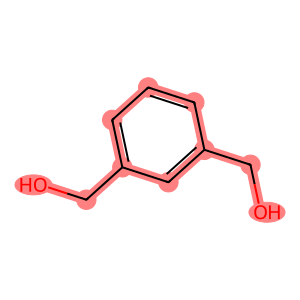

In [101]:
pmol

In [ ]:
# We need to transform top to itp and also for the future
# needs we need the functionality for parsing atoms and
# bonds sections. This will allow us to generate molecular
# graphs, which in turn, will allow us to compare molecules
# and prepare data for constant pH.
"""
We need to support two types of behaviour:
1. Easy case
    We generate molecule our selves with OpenFF.
    In this case we actually know what is the order atoms in
    all protonation states and we can easily do matching.
    We also know what to do with all possible states -
    symmetrical and with multiple hydrogens. From created
    interchanges and topology files we can get all the
    partial charges and then using rdkit and we can generate
    correct charge lists.
    We start by implementing this.
2. More complex case
    The topologies are provided by the user. In this case
    we:
        (i) expect that the user will provide us not only
            with the topologies, but also with structures
            for all states
        (ii) don't expect that the order of atoms is the
            same as in RdKit.
    We will reconstruct the order based on rdkit functionality
    https://greglandrum.github.io/rdkit-blog/posts/2022-12-18-introducing-rdDetermineBonds.html

    NOTE: in principal, the first case can also be treated
    as the second. But we will add it later.
In general, we need to read top/itp files (for now we always
expect [ atoms ] section to be present) and assign charges
in the order of mols[0]. For each state we additionally
treap symmetrical states and multi-H states. Then we change
the order according to the order in the first file.
"""
class GMX_topology:
    """
    Reads gromacs topology file and parses some of the sections.

    Parameters
    ----------
    gmx_top: str
        GROMACS topology file

    Attributes
    ----------
    blocks: Dict[str, str]
        Dictionary of blocks available in the topology file
    atoms: list

    Methods
    -------
    parse_atoms()
        Parse atom section if present. Generates at
    parse_atomtypes()
        Parse atomtypes section if present.
    parse_bonds()
        Parse bonds.


    """
    def __init__(self, gmx_top):
        self.blocks = {}
        with open(gmx_top, "r") as top:
            section = None
            tmp = []
            for line in top:
                if line.strip().startswith("["):
                    if section:
                        if section in self.blocks:
                            self.blocks[section] += [tmp]
                        else:
                            self.blocks[section] = [tmp]
                    else:
                        self.blocks["header"] = [tmp]
                    section = line.strip()[1:-1].strip()
                    tmp = []
                else:
                    tmp += [line]
            if section in self.blocks:
                self.blocks[section] += [tmp]
            else:
                self.blocks[section] = [tmp]

    def parse_atoms(self):
        """
        Parse atoms block. As a result, creates atoms attribute, where for each
        atom in the provided topology atomtype and index are stored
        """
        if "atoms" not in self.blocks:
            self.atoms = []
        else:
            self.atoms = []
            for section in self.blocks["atoms"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    self.atoms.append(
                        (
                            int(line.split()[0]) - 1,
                            line.split()[1],
                        )
                    )

    def parse_dihedrals(self):
        """
        Parse dihedral section of the topology. Only dihdrals of type 1 and 9
        with explicitly provided parameters are taken into account.
        """
        if "dihedrals" not in self.blocks:
            self.dihedrals = []
        else:
            self.dihedrals = []
            for section in self.blocks["dihedrals"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    if int(line.split()[4]) not in [1, 9]:
                        continue
                    if len(line.split()) < 8:
                        continue
                    self.dihedrals.append(
                        (
                            int(line.split()[0])-1,
                            int(line.split()[1])-1,
                            int(line.split()[2])-1,
                            int(line.split()[3])-1,
                            line
                        )
                    )

    def parse_dihedraltypes(self):
        """
        Parse dihedraltypes section in the topology if present. Creates
        dihedraltypes attribute, where types and of 4 atoms are provided
        and also the corresponding dihedral string (to ease the search in
        topology file). All imporpers and Fourier dihedrals are for now
        excluded. Thus, only type 1 and 9 are supported.
        https://manual.gromacs.org/current/reference-manual/topologies/topology-file-formats.html

        NOTE: We also should somehow iterate through difened torsions if they
        are present.
        """
        if "dihedraltypes" not in self.blocks:
            self.dihedraltypes = []
        else:
            self.dihedraltypes = []
            for section in self.blocks["dihedraltypes"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    if int(line.split()[4]) not in [1, 9]:
                        continue
                    self.dihedraltypes.append(
                        (
                            line.split()[0],
                            line.split()[1],
                            line.split()[2],
                            line.split()[3],
                            line[:(line.rfind(line.split()[3]) + len(line.split()[3]))].strip()
                        )
                    )

This is Molecule 0


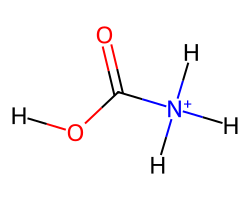

This is Molecule 1


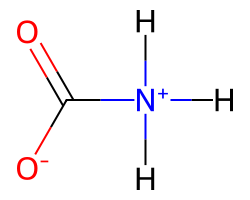

In [ ]:
#@title Provide topologies data
#@markdown If parameterisation is needed, all included molecules will be
#@markdown parameterized with open force field. If not, for all
is_parameterisation_needed = True #@param {type:"boolean"}
included_mols = [m for m,i in zip(mols, incl) if i]
included_svgs = [s for s,i in zip(svgs, incl) if i]
for i, s in enumerate(included_svgs):
    print(f"This is Molecule {i}")
    display(SVG(svgs[i]))

parameters_for_molecule_0 = "" #@param {type:"string"}
parameters_for_molecule_1 = "" #@param {type:"string"}
parameters_for_molecule_2 = "" #@param {type:"string"}
parameters_for_molecule_3 = "" #@param {type:"string"}
parameters_for_molecule_4 = "" #@param {type:"string"}

In [ ]:
from openff.interchange import Interchange

In [ ]:
inter = Interchange.from_smirnoff(force_field=ff, topology=top)

In [ ]:
inter.to_top("test.top")